# GTC Exposure Demonstration

## Contents
- 1.1 - [Initialisation - Choose Location](#Initialisation)
- 1.2 - [Visualise Subsequent Imagery](#visualiseImagery)
- 2   - [Settlement Segmentation - Random Forrest Classifier](#Settlement_Segmentation)
- 3.1 - [Detect Change - Thresholding Method](#thresholding)
- 3.2 - [Detect Change - Trained Classifier Method](#classifier)
- 3.3 - [Detect Change - Deep Learning Method](#deep_change)
- 4   - [Exposure Quantification](#exposure_quantification)

In [2]:
#import packages for plotting
import os
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from ipyleaflet import Map, basemaps, LocalTileLayer, ImageOverlay, ScaleControl, LayersControl

import settlement_segmentation.randomforest.demo_functions as rfc # Import functions from demo_functions.py
import change_detection.ratio_method.ir_demo_functions as dfn # Import functions from demoFunction.py
import change_detection.deep_change_detection.demo.demo_functions as dcd # Import functions from demo_functions.py
import exposure_quantification.exposure_demo as exq # Import functions from exposure_demo.py

PyTorch version 1.4.0 . If below 1.6.0 you may need to restart kernel.
IMPORTS OK


____________
<a id='Initialisation'></a>
### 1.1 Initialisation - Choose Location
Firstly we need to choose a location for which to detect change. You may either choose one of the locations with pre-assigned variables from the list displayed when running the first cell, or you can choose a new location by selecting 'New Location' which will then prompt you to provide variables of your own when running the second cell. Pre-set locations are the following:
- Training Set: Roseau, Dominica (pre-post hurricane Maria); Abricots, Haiti (pre-post hurricane Matthew)
- Test Set: Jeremie, Haiti (pre-post hurricane Matthew); Port Salut, Haiti (pre-post hurricane Matthew)
- Informal Settlements: Bidonville Killick Stenio Vincent, Port-au-Prince, Haiti (2018 to 2019); Parry Town, Ocho Rios, Jamaica (2018 to 2019)
- High Resolution: Hidalgo County, Texas, USA (2016 to 2019)

In [3]:
location = dfn.chooseLocation() # Generate pre-defined location list
location # Display location dropdown

Dropdown(description='Location:', options=(('train - Roseau, Dominica', 0), ('train - Abricots, Haiti', 1), ('…

In [6]:
variables = dfn.assignVariables(location) # Assign variables for chosen location
variables = dfn.submitNewLocation(variables) # Submits input variables for new location (if not new location - no action)

Button(description='Show variables', style=ButtonStyle())

Output()

_____________
<a id='visualiseImagery'></a>
### 1.1 - Visualise Imagery
We'll start by displaying before and after images for the chosen location. Two pointers here:
- You'll need to click the magic markers below the map to scale the imagery band colours properly. You can also untick the 'After' box to toggle between pre and post disaster.
- If you have defined a new location and no imagery appears for your location, try increasing the cloud fraction, but check this does not lead to overly cloudy images which may affect detection performance. Alternatively try changing or widening the requested dates, it is not uncommon to span several months for a good image.

In [7]:
# Create map with before and after images for specified location
dfn.beforeAfterImages(variables)


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


____________
<a id='Settlement_Segmentation'></a>
## 2 - Settlement Segmentation - Per Pixel Random Forrest Classifier
Locates where the informal setttlement are given an image from Sentinel-2

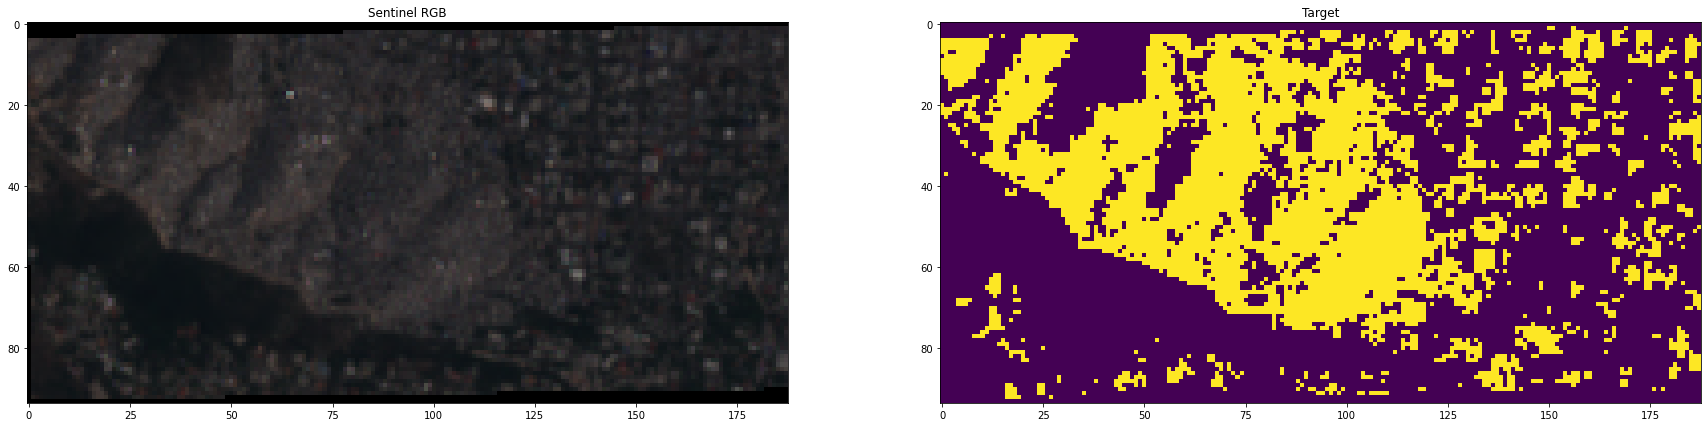

In [8]:
rfc.classify(variables, 'killick_classifier.pkl')

______________
## 3 - Change Detection - Image Ratio Demo
This detects change between satellite images taken at subsequent times over the same location.

The methods are calibrated on [Sentinel-2](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/overview) pre-post disaster imagery from the Caribbean and [Copernicus Emergency Mapping Service (EMS)](https://emergency.copernicus.eu/mapping/map-of-activations-rapid#zoom=3&lat=29.18235&lon=-70.57787&layers=BT00) ground truth damage assessment data. Section 4 allows you to evaluate predicted damages against reported damages for locations covered by EMS. The models were built using the [Descartes Labs](https://www.descarteslabs.com/) platform. If you wish to re-train the models or have more flexibility in your parameters, plots or methods, please visit the notebooks for each method at [thresholding.ipynb](./thresholding.ipynb) and [unet_classifier.ipynb](./unet_classifier.ipynb).

______
<a id='thresholding'></a>
### 3.1 - Detect Change - Ratio Thresholding
Next, let's take the logarithmic ratio of images for selected bands and display detected change superimposed on the image for time 2. Beneath the plot is a slider allowing you to vary the thresholds within which we are detecting change. If damage assessment data is available for the location this will be overlayed for a qualitative comparison.

> The optimal threshold interval for detecting building change has been determined as 0.01-0.1. However, due to differences in lighting between repeat images this may need adjsuted according to location. As the ratio is logarithmic, if the second image is considerably darker than the first, the appropriate thresholding may even be negative.

Detection interval equation for RGB (red, green and blue bands) where, for example, r1 denotes pixel value for red band at time 1:  $ threshold < \log\left(\frac{r2}{r1} \times \frac{b2}{b1} \times \frac{g2}{g1}\right) < cap  $

In [9]:
# Function to detect change through thresholding for location
plotVars = dfn.thresholding(variables)

`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jup…

FloatRangeSlider(value=(0.1, 0.3), description='Filter ratios', max=0.5, min=-0.5, step=0.01)

Run box below to display updated detection result


You may observe 2 main limitations with this method.
- Lack of small scale change detections due to 10x10m resolution of Sentinel Imagery. Try re-running the notebook selecting the high resolution location to see what is possible where 1x1m resolution is available.
- Sensitivity of thresholding to image lighting and changes in areas other than buildings, due to effect on ratio values. If threshold is unadjusted or mask is not applied to ocean this leads to false detections. To mitigate this limitation we trained a [classifier](#classifier) in the next section to recognise the evidence of damage buildings within the image ratio rather than relying on simple thresholding.
____________________
<a id='classifier'></a>
### 3.2 - Detect Change - Ratio Classifier
To avoid the drawbacks of thresholding we trained a Convolutional Neural Network (CNN) with a [U-Net](https://arxiv.org/abs/1505.04597) architecture to identify building change from the pixel ratios between before/after Sentinel-2 imagery. This model evaluates change per 'image tile' of which there will be many within your area of interest. Therefore, first let's draw a polygon over the desired area. Then, each corresponding tile will individually be fed in to the model for assessing change detection. Bare in mind the larger the area the longer it will take to run the model for that area.
> One could question the decision not to just increase tilesize. However not only does this method make the evaluation area more flexible, but also the model does not cater well for tile sizes larger than that for which it was trained due to the input layer structure.

In [10]:
m3, testPoly = dfn.drawPolygon(variables) # Get map upon which to draw polygon for assessment
m3 # Display map


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


In [11]:
# Detect change for all tiles at least partly within polygon
dfn.classifyDamage(testPoly, variables, m3)

Longitude Columns:   0%|          | 0/1 [00:00<?, ?it/s]

Number of tiles requested: 1 . Approximately 8 seconds on 16GB RAM.

Job ID: d07b3465173f53c04016b851f04a69d5c934ff1d7874c6e9
[######] | Steps: 373/373 | Stage: SUCCEEDED                                  


Latitude Rows: 100%|██████████| 1/1 [00:53<00:00, 53.68s/it]


____________
<a id='deep_change'></a>
### 3.3 - Change Detection - Deep Learning Method


In [12]:
output = dcd.run_model()

/home/jovyan/gtc-exposure/change_detection/deep_change_detection/demo/demo_functions.py:144: UserWarning: /home/jovyan/gtc-exposure/change_detection/deep_change_detection/demo/new/killick_0/cm/cm.png is a low contrast image
  io.imsave(imgFolder+"/cm/cm.png", imgconv)
/home/jovyan/gtc-exposure/change_detection/deep_change_detection/demo/demo_functions.py:144: UserWarning: /home/jovyan/gtc-exposure/change_detection/deep_change_detection/demo/new/killick_1/cm/cm.png is a low contrast image
  io.imsave(imgFolder+"/cm/cm.png", imgconv)
  0%|          | 0/2 [00:00<?, ?it/s]

killick_0
(512, 512, 4) (512, 512, 4)
killick_1
(512, 512, 4) (512, 512, 4)
abudhabi
(799, 785, 4) (795, 782, 4)
LOAD OK


/home/jovyan/gtc-exposure/change_detection/deep_change_detection/demo/utils_cd.py:233: UserWarning: /home/jovyan/gtc-exposure/change_detection/deep_change_detection/demo/results/FC-EF-killick_0.png is a low contrast image
  io.imsave(f'{os.getcwd()}/change_detection/deep_change_detection/demo/results/{net_name}-{name}.png',I)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████     | 1/2 [00:03<00:03,  3.01s/it]/home/jovyan/gtc-exposure/change_detection/deep_change_detection/demo/utils_cd.py:233: UserWarning: /home/jovyan/gtc-exposure/change_detection/deep_change_detection/demo/results/FC-EF-killick_1.png is a low contrast image
  io.imsave(f'{os.getcwd()}/change_detection/deep_change_detection/demo/results/{net_name}-{name}.png',I)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
100%|██████████| 2/2 [00:13<00:00,  6.87s/it]

Check out imagery results


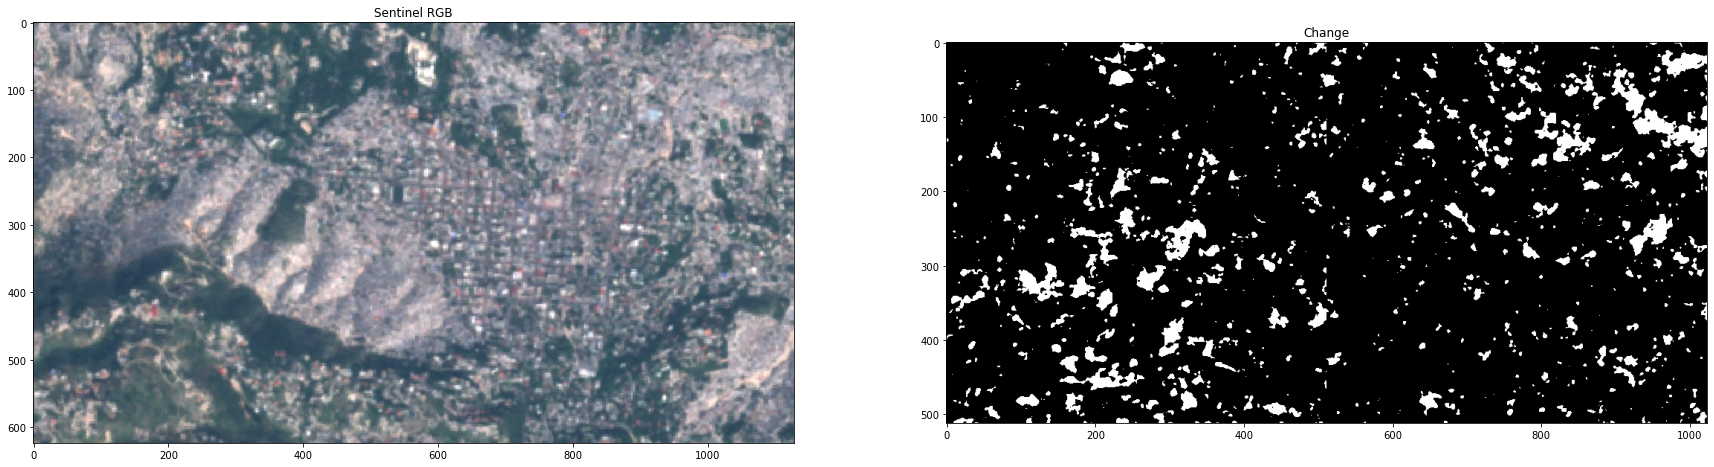

In [14]:
dcd.display_results(output)

____________
<a id='exposure_quantification'></a>
### 4 - Exposure Quantification

In [15]:
center, zoom, rel_url_S2, rel_url_BU, rel_url_POP, bounds = exq.exposure_quantification()
print(rel_url_S2, rel_url_BU, rel_url_POP)
m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=center, zoom=zoom)
m.add_control(ScaleControl(position='bottomleft'))
m.add_layer(ImageOverlay(name='Sentinel-2 Composite', url=rel_url_S2, bounds=bounds))
m.add_layer(ImageOverlay(name='GHSL Built-up Probability', url=rel_url_BU, bounds= bounds, opacity=0.7))
m.add_layer(ImageOverlay(name='GHSL Population Density', url=rel_url_POP, bounds=bounds, opacity=0.5))
m.add_control(LayersControl(position='topright'))
m

/home/jovyan/gtc-exposure/exposure_quantification/GHS_S2_Haiti.png /home/jovyan/gtc-exposure/exposure_quantification/GHS_BU_2.png /home/jovyan/gtc-exposure/exposure_quantification/GHS_POP_2.png


Map(center=[18.51097696266426, -72.29284267872913], controls=(ZoomControl(options=['position', 'zoom_in_text',…

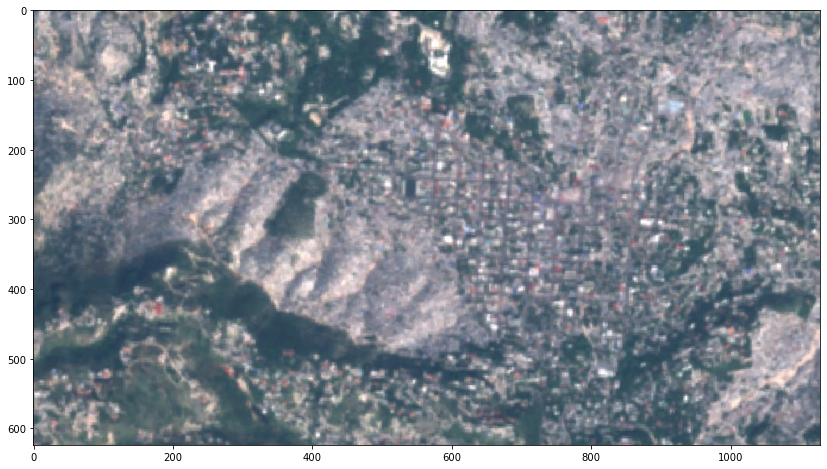

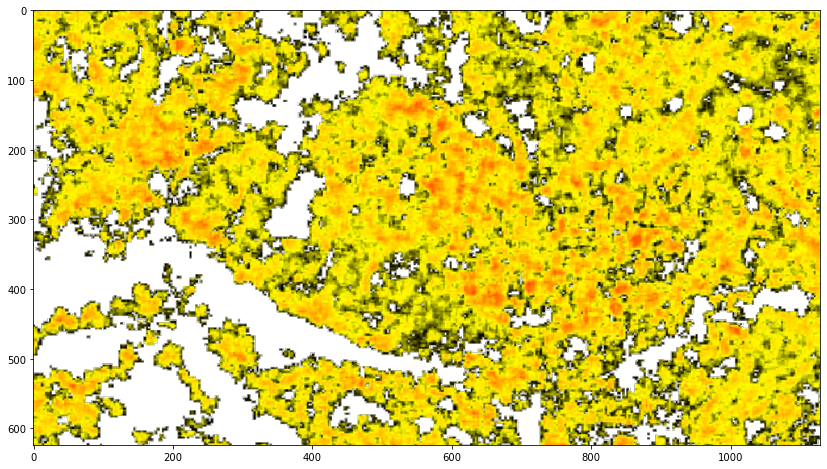

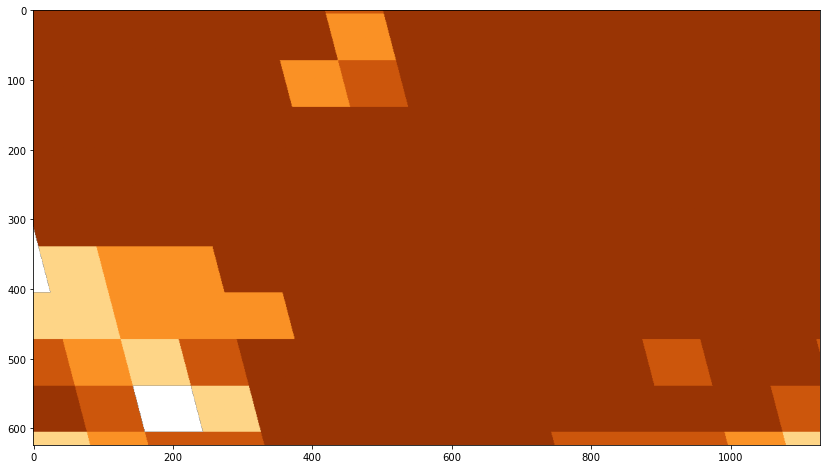

In [17]:
import matplotlib.image as mpimg
plt.figure(figsize = (15,8))
img = mpimg.imread(rel_url_S2)
plt.imshow(img)
plt.show()
plt.figure(figsize = (15,8))
img = mpimg.imread(rel_url_BU)
plt.imshow(img)
plt.show()
plt.figure(figsize = (15,8))
img = mpimg.imread(rel_url_POP)
plt.imshow(img)
plt.show()